# **Problem 3: Variational Autoencoders**

## **About**

### **Due**

Monday 10/16/20, 11:59 PM CST

### **Goal**

This homework focuses on creating variational autoencoders applied to the MNIST dataset.

### Installing PyTorch and Dependencies

The instructions for installing and setting up PyTorch can be found at https://pytorch.org/get-started/locally/. Make sure you follow the instructions for your machine.\
Check that PyTorch installed correctly by running the following:

In [7]:
import torch
torch.rand(5, 3)

tensor([[0.1757, 0.8194, 0.0205],
        [0.9630, 0.5479, 0.8196],
        [0.8267, 0.7883, 0.4878],
        [0.4191, 0.2921, 0.3562],
        [0.3534, 0.3148, 0.1180]])

The output should look something like

```python
tensor([[0.3380, 0.3845, 0.3217],
        [0.8337, 0.9050, 0.2650],
        [0.2979, 0.7141, 0.9069],
        [0.1449, 0.1132, 0.1375],
        [0.4675, 0.3947, 0.1426]])
```

### Let's get started with the assignment.

## **Instructions**

### **Part 1 - Datasets and Dataloaders**


**Create a directory named problem3_data with the following command.**

In [8]:
!mkdir problem3_data

mkdir: cannot create directory ‘problem3_data’: File exists



**Now use `torch.datasets.MNIST` to load the Train and Test data into `problem3_data`.** 
* ** Use the directory you created above as the `root` directory for your datasets**
* ** Populate the `transformations` variable with any transformations you would like to perform on your data.** (Hint: You will need to do at least one)
* **Pass your `transformations` variable to `torch.datasets.MNIST`. This allows you to perform arbitrary transformations to your data at loading time.**

In [10]:
from torchvision import datasets, transforms

## YOUR CODE HERE ##
batch_size = 32
loc_data = 'problem3_data'
latent_dim = 10
transformations = transforms.ToTensor()
mnist_train =  datasets.MNIST(loc_data, train=True, download=True, transform = transformations)
mnist_test = datasets.MNIST(loc_data, train=False, download=True, transform = transformations)

**Any file in our dataset will now be read at runtime, and the specified transformations we need on it will be applied when we need it.**. 

We could iterate through these directly using a loop, but this is not idiomatic. PyTorch provides us with this abstraction in the form of `DataLoaders`. The module of interest is `torch.utils.data.DataLoader`. 

`DataLoader` allows us to do lots of useful things
* Group our data into batches
* Shuffle our data
* Load the data in parallel using `multiprocessing` workers

**Use `DataLoader` to create a loader for the training set and one for the testing set**
* **Use a `batch_size` of 32 to start, you may change it if you wish.**
* **Set the `shuffle` parameter to `True`.** 

**Check that the data was loaded successfully before proceeding to the next sections. **

In [11]:
from torch.utils.data import DataLoader

## YOUR CODE HERE ##
train_loader = DataLoader(mnist_train,batch_size=batch_size,drop_last = True,shuffle=True)
test_loader = DataLoader(mnist_test,batch_size=batch_size,drop_last = True,shuffle=True)

## **Part 2 - Encoder and Decoders (0 points)**

In this section we will be creating the encoder and decoder for our variational autoencoder (VAE). 

You can take a look at the following to understand how VAE's work. 

*   https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf
*  http://kvfrans.com/variational-autoencoders-explained/
*  https://jmetzen.github.io/2015-11-27/vae.html

VAEs work around a latent space who's dimension can be chosen by us. We will leave this as a parameter for the Encoder and Decoder classes that you will have to populate. 

Feel free to use any network architecture that you wish. Try simpler network structures like a few linear layers before trying anything more complicated. 

### For the Encoder:

*   **Finish the __init__() function.**
*  **Finish the forward() function.** 
*  **Assume that input to forward, x, is of shape (batch_size, 28,28)**
*  **forward() should return two tensors of size latent_dim like a standard encoder of a VAE**
* **One of the tensors should correspond to the mean of the encoding and the other tensor should correspond to the variance. In practice, it is easier to model the output as the log of the variance (logvar) and we will too**

### For the Decoder:

*   **Finish the __init__() function.**
*  **Finish the forward() function.** 
*  **Assume that input to forward, x, is of shape (batch_size, latent_dim)**
*  **forward() should return a tensor of shape (batch_size, 28,28)**
* **Make sure that the output lies in the same range as the input to the encoder (Hint: Sigmoid?)**







In [12]:
test_loader

In [5]:
from torch import nn
class Encoder(nn.Module):
  def __init__(self, latent_dim):
    super(Encoder, self).__init__()
    self.latent_dim = latent_dim
    self._encoder = nn.Sequential(nn.Linear(in_features = 28*28, out_features = 512),nn.ReLU(),nn.Linear(in_features = 512, out_features = 2*latent_dim))
  
  def forward(self, x):
    x = x.reshape((-1,28*28))    
    x = torch.reshape(self._encoder.forward(x), (-1, 2, self.latent_dim))
    mu, logvar = x[:,0,:], x[:,1,:]
    return mu, logvar, sample(mu, logvar) 

class Decoder(nn.Module):
  def __init__(self, latent_dim=10):
    super(Decoder, self).__init__()
    self.latent_dim = latent_dim
    self._decoder = nn.Sequential(nn.Linear(in_features = latent_dim, out_features = 512),nn.ReLU(),nn.Linear(in_features = 512, out_features = 28*28),nn.Sigmoid())
    
  def forward(self,x):
    return self._decoder.forward(x).reshape((-1,28,28))

32768it [00:04, 6983.75it/s]             
1654784it [00:04, 369439.26it/s]                              
8192it [00:03, 2272.10it/s]             
9920512it [00:09, 1074155.91it/s]                             


## **Part 3: Training and loss functions** (0 points)

Recall that the encoder outputs the mean (mu) and the log of the variance (logvar). This implies that the latent vector of the input image follows a gaussian distribution with mean (mu) and standard deviation (e^[0.5\*logvar]). To decode this information, the decoder needs a sample from this distribution. 

**Complete the sample function to generate these samples **

In [6]:
def sample(mu, logvar):
  z = torch.randn_like(mu)
  return mu + torch.mul(torch.exp(0.5*logvar), z)

We also need to create the loss function. Assume that x are your input images and x_hat are your reconstructions of these input images, complete the following loss for a VAE. (Hint: You will need to use mu and logvar as well)

In [7]:
def vae_loss(x, x_hat, mu, logvar):
  mse = (x_hat - x).pow(2).sum()/(x.shape[0]*1.0)
  KL_loss = 0.5*torch.sum(-1 + torch.pow(mu,2) - logvar + torch.exp(logvar))/(x.shape[0]*1.0)
  return torch.add(mse, KL_loss)

In the following we will instantiate an Encoder and Decoder with a latent dimension of 32.

We also define a single optimizer that optimizes the parameters of both the Encoder and the Decoder together. Feel free to use any optimizer of your choice. 

In [8]:
from torch import optim

encoder = Encoder(latent_dim)
decoder = Decoder(latent_dim)
params = list(encoder.parameters())+list(decoder.parameters())
optimizer = optim.Adam(params, lr=1e-3)

Complete the train function that takes input encoder, decoder, train_loader, optimizer, and number of epochs you wish to train your model for.

Training will involve:

1.   **One epoch is defined as a full pass of your dataset through your model. We choose the number of epochs we wish to train our model for.**
2.   **For each batch, use the encoder to generate the mu and logvar.**
3. **Sample a latent vector for each image in the batch and feed this to the decoder to generate the decoded images.**
4. **Calculate the loss function for this batch.**
5. **Now calculate the gradients for each parameter you are optimizing over. (Hint: Your loss function object can do this for you)**
6. **Update your model parameters (Hint: The optimizer comes in here)**
7. ** Set the gradients in your model to zero for the next batch.**



In [9]:
def train(encoder, decoder, train_loader, optimizer, num_epochs = 10):  
  encoder.train()
  decoder.train()
  for i in range(num_epochs):
    print("Epoch {}".format(i))
    for j, (x, y) in enumerate(train_loader):
        x = x.reshape((-1,28,28))
        _mu, _logvar, _z = encoder.forward(x)
        x_hat = decoder.forward(_z)
        optimizer.zero_grad()
        loss = vae_loss(x, x_hat, _mu, _logvar)
        loss.backward()
        optimizer.step()
        if j % 100 == 0:
            print(loss)            
  return loss

Finally call train with the relevant parameters.

Note : This function may take a while to complete if you're training for many epochs on a cpu. This is where it comes in handy to be running on Google Colab, or just have a GPU on hand.

In [ ]:
train(encoder, decoder, train_loader, optimizer, num_epochs = 100)

Epoch 0
tensor(185.2799, grad_fn=<AddBackward0>)
tensor(54.7616, grad_fn=<AddBackward0>)
tensor(42.2387, grad_fn=<AddBackward0>)
tensor(38.3703, grad_fn=<AddBackward0>)
tensor(38.9633, grad_fn=<AddBackward0>)
tensor(35.7212, grad_fn=<AddBackward0>)
tensor(39.7583, grad_fn=<AddBackward0>)
tensor(37.2214, grad_fn=<AddBackward0>)
tensor(35.2419, grad_fn=<AddBackward0>)
tensor(35.1537, grad_fn=<AddBackward0>)
tensor(34.4609, grad_fn=<AddBackward0>)
tensor(35.8811, grad_fn=<AddBackward0>)
tensor(34.8106, grad_fn=<AddBackward0>)
tensor(34.9109, grad_fn=<AddBackward0>)
tensor(34.8184, grad_fn=<AddBackward0>)
tensor(37.0253, grad_fn=<AddBackward0>)
tensor(33.1781, grad_fn=<AddBackward0>)
tensor(34.4690, grad_fn=<AddBackward0>)
tensor(33.1365, grad_fn=<AddBackward0>)
Epoch 1
tensor(32.0516, grad_fn=<AddBackward0>)
tensor(34.2073, grad_fn=<AddBackward0>)
tensor(31.2793, grad_fn=<AddBackward0>)
tensor(30.4061, grad_fn=<AddBackward0>)
tensor(33.3843, grad_fn=<AddBackward0>)
tensor(31.2590, grad_fn

## **Part 4: Visualizing the VAE output** (50 points)

We will look at how well the codes produced by the VAE can be interpolated. **For this section we will only use the MNIST test set. **

To create an interpolation between two images A and B, we encode both these images and generate a sample code for each of them. We now consider 7 equally spaced points in between these two sample codes giving us a total of 9 points including the samples. We then decode these images to get interpolated images in between A and B.

Complete the interpolation function below that takes a pair of images A and B and returns 9 images. (You are free to use any data structure you want to return these images)

In [11]:
import matplotlib.pyplot as plt
from torchvision import utils
%matplotlib inline
import numpy as np

def create_interpolates(A, B, encoder, decoder):
  ## Assuming A and B are images of shape (28,28)
  _, _, zA = encoder(A.reshape((-1, 28*28)))  
  _, _, zB = encoder(B.reshape((-1, 28*28)))
  image_list = []
  nimages = 9
  dZ = zB - zA
  z_list = [zA + dZ*(i*1.0/(nimages-1)) for i in range(nimages)]
  image_list = []
  for z in z_list:
    image_list.append(decoder(z).reshape((28,28)).detach().numpy())
  return np.concatenate(tuple(image_list), axis = 1)

**For 10 pairs of MNIST test images of the same digit (1 pair for "0", 1 pair for "1", etc.), selected at random, compute the code for each image of the pair. Now compute 7 evenly spaced linear interpolates between these codes, and decode the result into images. Prepare a figure showing this interpolate. Lay out the figure so each interpolate is a row. On the left of the row is the first test image; then the interpolate closest to it; etc; to the last test image. You should have a 10 rows (1 row per digit) and 9 columns (7 interpolates + 2 selected test images) of images. (25 points)**

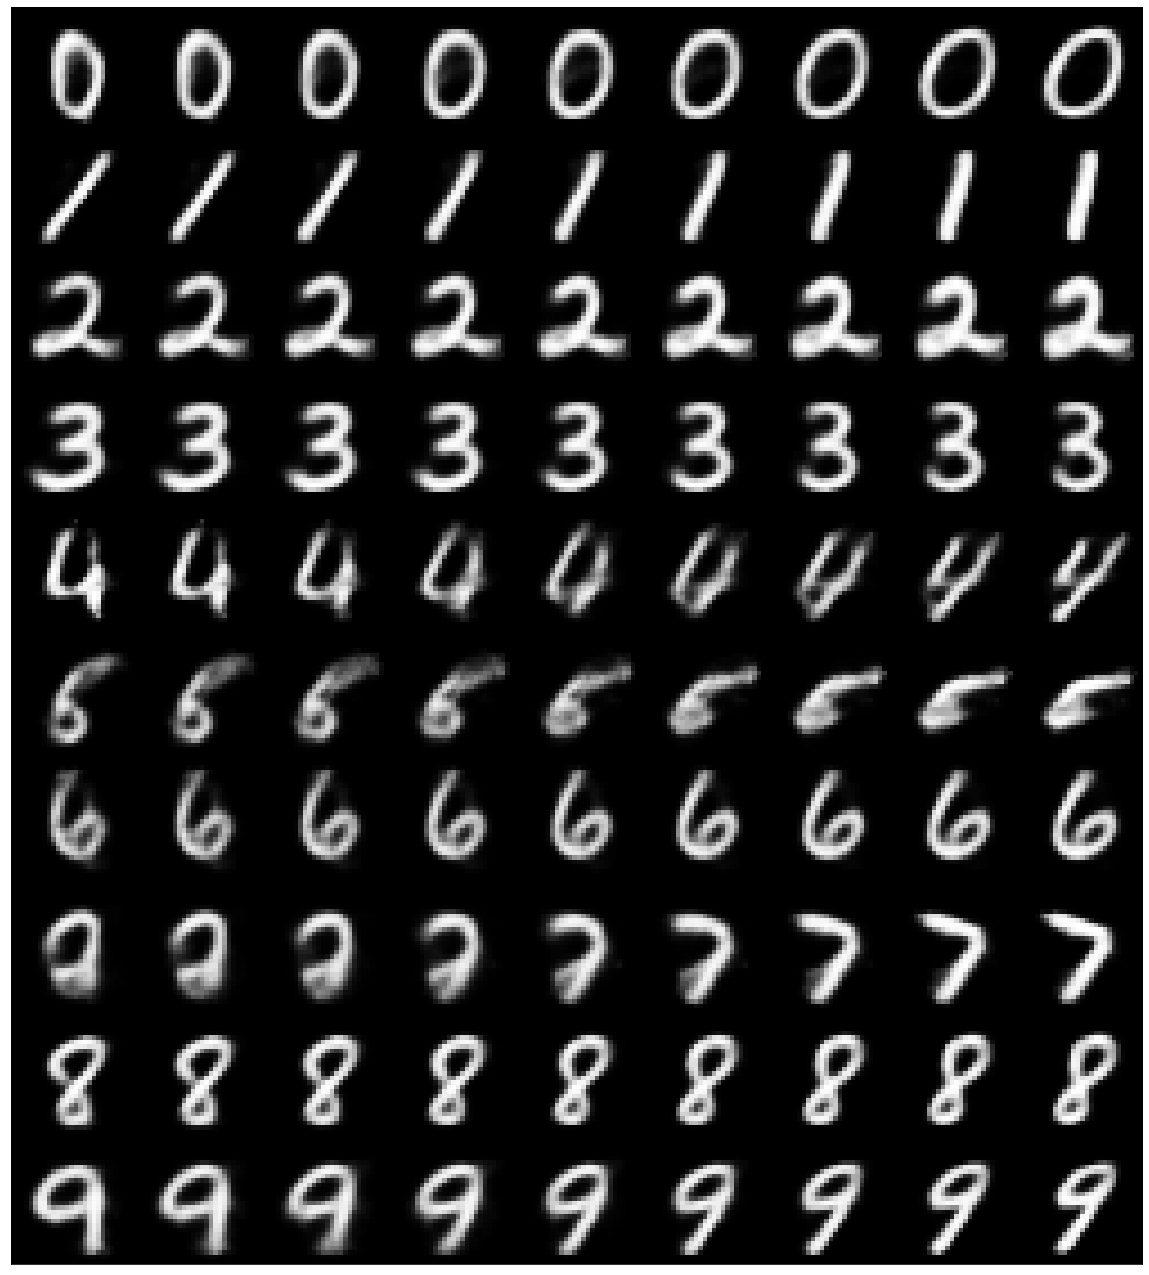

In [12]:
similar_pairs = {}
for _, (x, y) in enumerate(test_loader):
  for i in range(len(y)):
    if y[i].item() not in similar_pairs:
      similar_pairs[y[i].item()] = []
    if len(similar_pairs[y[i].item()])<2:
      similar_pairs[y[i].item()].append(x[i])
  
  done = True
  for i in range(10):
    if i not in similar_pairs or len(similar_pairs[i])<2:
      done = False
  
  if done:
    break

# similar_pairs[i] contains two images indexed at 0 and 1 that have images of the digit i

fig = plt.figure(figsize=(20,18))
for i in sorted(similar_pairs.keys()):
  images = create_interpolates(similar_pairs[i][0], similar_pairs[i][1], encoder, decoder) 
  plt.subplot(10,1,i +1)
  plt.tight_layout()
  plt.imshow(images, cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])
  plt.subplots_adjust(wspace=0, hspace=0)

**For 10 pairs of MNIST test images, selected at random, compute the code for each image of the pair. Now compute 7 evenly spaced linear interpolates between these codes, and decode the result into images. Prepare a figure showing this interpolate. Lay out the figure so each interpolate is a row. On the left of the row is the first test image; then the interpolate closest to it; etc; to the last test image. You should have a 10 rows and 9 columns of images. (25 points)**

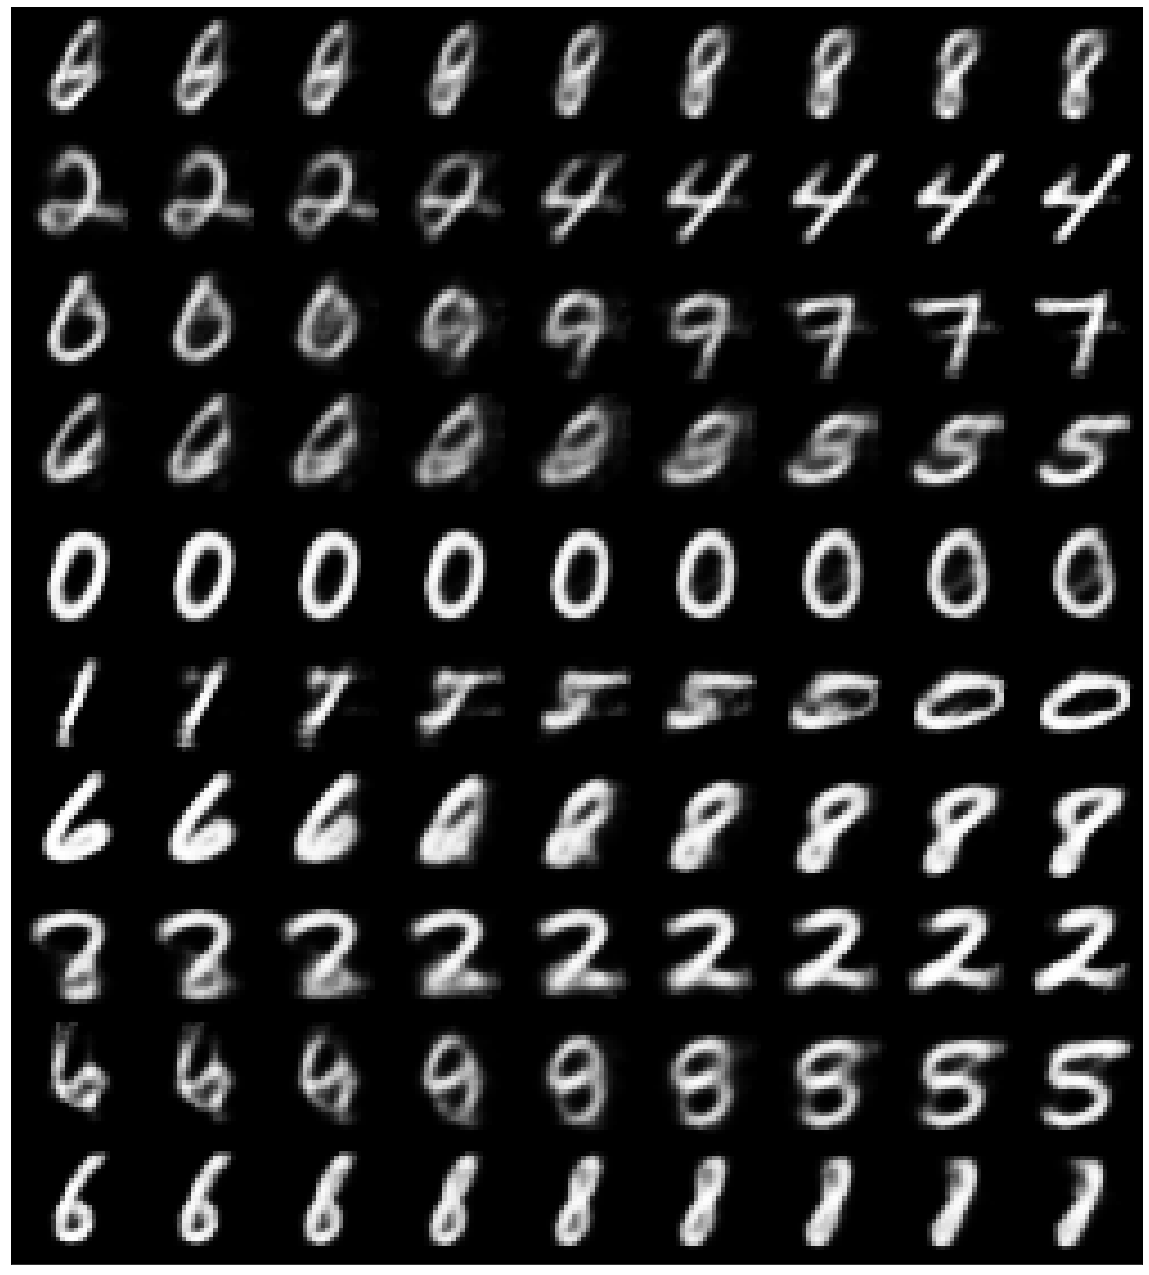

In [13]:
random_pairs = {}
for _, (x, y) in enumerate(test_loader):
  # Make sure the batch size is greater than 20
  for i in range(10):
    random_pairs[i] = []
    random_pairs[i].append(x[2*i])
    #print(y[2*i].item())
    random_pairs[i].append(x[2*i+1])
    #print(y[2*i+1].item())
  break

# random_pairs[i] contains two images indexed at 0 and 1 that are chosen at random

fig = plt.figure(figsize=(20,18))
for i in sorted(random_pairs.keys()):
  images = create_interpolates(random_pairs[i][0], random_pairs[i][1], encoder, decoder) 
  plt.subplot(10,1,i +1)
  plt.tight_layout()
  plt.imshow(images, cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])
  plt.subplots_adjust(wspace=0, hspace=0)

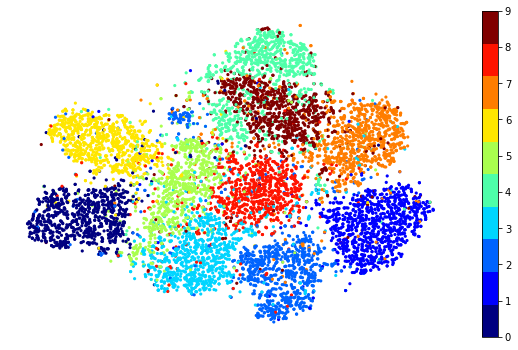

In [123]:
from sklearn.manifold import TSNE


Imageslist = []
Tmageslabel = []
# get all the test images and labels in test set and use encode to compute the latent vector z
for i, data in enumerate(test_loader):
    inputs, labels = data
    for j in range(len(labels)):
        Imageslist.append(inputs[j])
        Tmageslabel.append(labels[j].item())

#convert the tensor into numpy
test_features = []
for i in range(len(Imageslist)):
     _, _, z = encoder(Imageslist[i])
     z = z.detach().numpy()
     z = np.squeeze(z)
     test_features.append(z)
    
test_features = np.array(test_features)
test_labels = np.array(Tmageslabel)

#reduce dimensionality to 2D, we consider a subset of data because TSNE
tsne_features = TSNE(n_components=2).fit_transform(test_features)

fig = plt.figure(figsize=(10, 6))

plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=test_labels[:tsne_features.shape[0]], marker='o',
            edgecolor='none', cmap=plt.cm.get_cmap('jet', 10), s = 10)
plt.grid(False)
plt.axis('off')
plt.colorbar()